# Running DeepAR on first set of Munchkin data

Separately loaded up a subset of the Munchkin data into S3, prepped into the format that DeepAR expects to use.

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

In [3]:
# Sometimes seems like I have to reinstall s3fs, even though I only stopped and started the instance. That seems odd.
# But leaving in command in case its needed.

# !conda install -y s3fs

In [2]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

Let's start by specifying:  
* The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
* The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Here we use the get_execution_role function to obtain the role arn which was specified when creating the notebook.

In [4]:
bucket = 'sagemaker-w210-0223'
prefix = 'Deeptest_1'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

Next, we configure the container image to be used for the region that we are running in.

In [5]:
containers = {
    'us-east-1': '522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:latest',
    'us-east-2': '566113047672.dkr.ecr.us-east-2.amazonaws.com/forecasting-deepar:latest',
    'us-west-2': '156387875391.dkr.ecr.us-west-2.amazonaws.com/forecasting-deepar:latest',
    'eu-west-1': '224300973850.dkr.ecr.eu-west-1.amazonaws.com/forecasting-deepar:latest'
}
image_name = containers[boto3.Session().region_name]

## Specify overall parameters

Specify we have weekly frequency data.  

Want to predict for the next 17 weeks (to allow us to predict weeks 14-17 before week 1, which is the business use case).

Going to choose to use 26 weeks of context to make the predictions.  (Note: DeepAR automatically checks for typical seasonal windows with lagged inputs so don't need to specify a window greater than a year for it to include seasonal effects.)

In [6]:
freq = 'W'
prediction_length = 17
context_length = 26

## Train a model

We can now define the estimator that will launch the training job.

Have picked data of the same order of magnitude as the tutorial, so just leave the same instance specifications for now, except for job name.

In [7]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DeepAR-M1',
    output_path="s3://" + s3_output_path
)

Now need to set hyperparameters.

Keeping the network size the same as the tutorial example.

Set likelihood to negative binomial as we have count data

Leave epochs, batch size, learning rate as in the tutorial.

In [8]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "negative-binomial",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [9]:
estimator.set_hyperparameters(**hyperparameters)

In [10]:
s3_data_path

'sagemaker-w210-0223/Deeptest_1/data'

Now launch the training job. SageMaker will start an EC2 instance, download the data from S3, start training the model and save the trained model.

If you provide the test data channel, as we do in this example, DeepAR will also calculate accuracy metrics for the trained model on this test data set. This is done by predicting the last prediction_length points of each time series in the test set and comparing this to the actual value of the time series. The computed error metrics will be included as part of the log output.

Note: the next cell may take a few minutes to complete, depending on data size, model complexity, and training options.

In [11]:
%%time

data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DeepAR-M1-2018-04-08-18-45-45-002


.........................................................
Arguments: train
[04/08/2018 18:50:23 INFO 139744515852096] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'dropout_rate': u'0.05', u'cardinality': u'', u'test_quantiles': u'[0.5, 0.9]', u'_num_gpus': u'auto', u'learning_rate': u'0.001', u'_kvstore': u'auto', u'num_layers': u'3', u'embedding_dimension': u'', u'num_cells': u'40', u'_num_kv_servers': u'auto', u'mini_batch_size': u'32', u'likelihood': u'gaussian', u'early_stopping_patience': u''}
[04/08/2018 18:50:23 INFO 139744515852096] Reading provided configuration from /opt/ml/input/config/hyperparameters.json: {u'dropout_rate': u'0.05', u'learning_rate': u'0.001', u'num_cells': u'40', u'prediction_length': u'17', u'epochs': u'20', u'time_freq': u'W', u'context_length': u'26', u'num_layers': u'3', u'mini_batch_size': u'32', u'likelihood': u'negative-binomial', u'early_stopping_patience': u'10'}
[04/08/2018 18:50:23 IN

[04/08/2018 18:50:32 INFO 139744515852096] Epoch[7] Batch[5] avg_epoch_loss=7.620426
[04/08/2018 18:50:32 INFO 139744515852096] Epoch[7] Batch [5]#011Speed: 549.31 samples/sec#011loss=7.620426
[04/08/2018 18:50:32 INFO 139744515852096] Epoch[7] Batch[10] avg_epoch_loss=7.383937
[04/08/2018 18:50:32 INFO 139744515852096] Epoch[7] Batch [10]#011Speed: 587.23 samples/sec#011loss=7.100150
[04/08/2018 18:50:32 INFO 139744515852096] Epoch[7] Batch[15] avg_epoch_loss=7.453919
[04/08/2018 18:50:32 INFO 139744515852096] Epoch[7] Batch [15]#011Speed: 513.03 samples/sec#011loss=7.607880
[04/08/2018 18:50:33 INFO 139744515852096] processed a total of 640 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 1130.9151649475098, "sum": 1130.9151649475098, "min": 1130.9151649475098}}, "EndTime": 1523213433.19321, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1523213432.04978}

[04/08/2018 18:50:33 INFO 139744515852096] best epoch loss s

[04/08/2018 18:50:42 INFO 139744515852096] Epoch[16] Batch[10] avg_epoch_loss=7.358762
[04/08/2018 18:50:42 INFO 139744515852096] Epoch[16] Batch [10]#011Speed: 516.49 samples/sec#011loss=6.907924
[04/08/2018 18:50:42 INFO 139744515852096] Epoch[16] Batch[15] avg_epoch_loss=7.270959
[04/08/2018 18:50:42 INFO 139744515852096] Epoch[16] Batch [15]#011Speed: 618.46 samples/sec#011loss=7.077792
[04/08/2018 18:50:42 INFO 139744515852096] processed a total of 576 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 997.9710578918457, "sum": 997.9710578918457, "min": 997.9710578918457}}, "EndTime": 1523213442.966567, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1523213441.948486}

[04/08/2018 18:50:42 INFO 139744515852096] loss did not improve for 3 epochs
[04/08/2018 18:50:43 INFO 139744515852096] Epoch[17] Batch[0] avg_epoch_loss=7.728603
[04/08/2018 18:50:43 INFO 139744515852096] Epoch[17] Batch[5] avg_epoch_loss=7.572896
[

## Create endpoint and predictor

Now that we have trained a model, we can use it to perform predictions by deploying it to an endpoint.

**Note**: remember to delete the enpoint after running this experiment. A cell at the very bottom of this notebook will do that: make sure you run it at the end.

In [12]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DeepAR-M1-2018-04-08-18-45-45-002
INFO:sagemaker:Creating endpoint-config with name DeepAR-M1-2018-04-08-18-45-45-002
INFO:sagemaker:Creating endpoint with name DeepAR-M1-2018-04-08-18-45-45-002


-----------------------------------------------------------------------------!

To query the endpoint and perform predictions, we can define the following utility class: this allows making requests using pandas.Series objects rather than raw JSON strings.

In [13]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [14]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

In [15]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions and plot results

First read back in the JSON objects and convert them into lists of Pandas Series to conform with the way the tutorial code was set up.

In [16]:
def get_deepar_data(filepath):
    s3filesystem = s3fs.S3FileSystem()
    encoding = "utf-8"

    with s3filesystem.open(filepath, "rb") as fp:
        data = fp.read()

    data_list = []
    for ts in data.decode(encoding).splitlines():
        ts = json.loads(ts)
        time_index = pd.DatetimeIndex(start = ts["start"], freq = freq, periods = len(ts["target"]))
        data_list.append(pd.Series(index = time_index, data = ts["target"]))
        
    return data_list

In [17]:
test_data = get_deepar_data("{}/test/test.json".format(s3_data_path))
pred_data = get_deepar_data("{}/train/train.json".format(s3_data_path))

Now we can use the previously created predictor object. First, we will predict only the first few time series used for training, and visualize the results with the actual data we kept in the test set.

In [18]:
list_of_df = predictor.predict(pred_data[:5])
actual_data = test_data[:5]

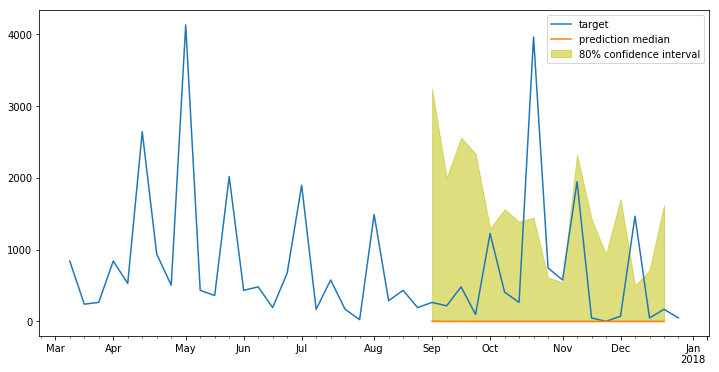

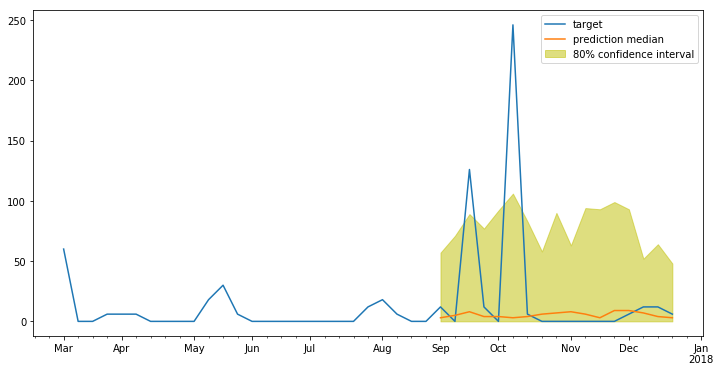

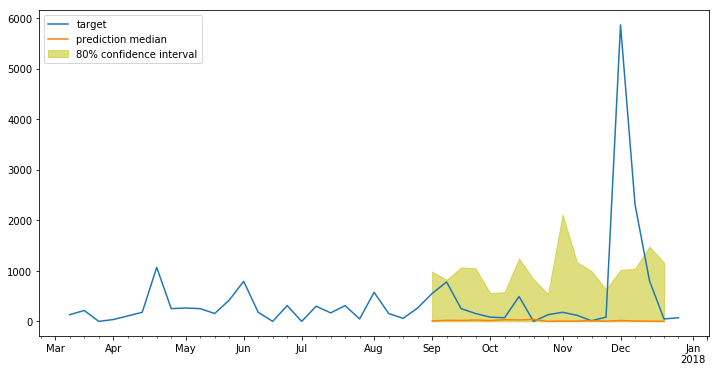

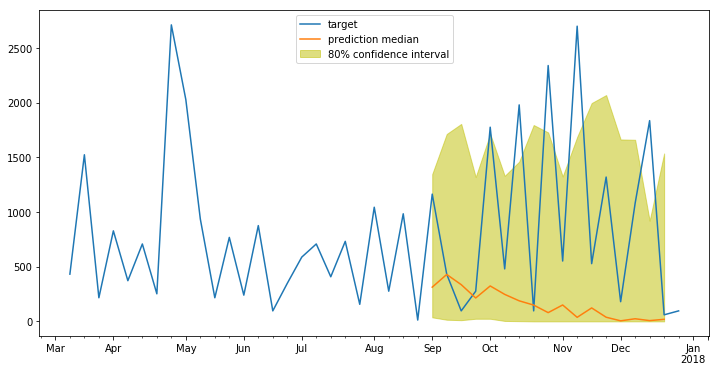

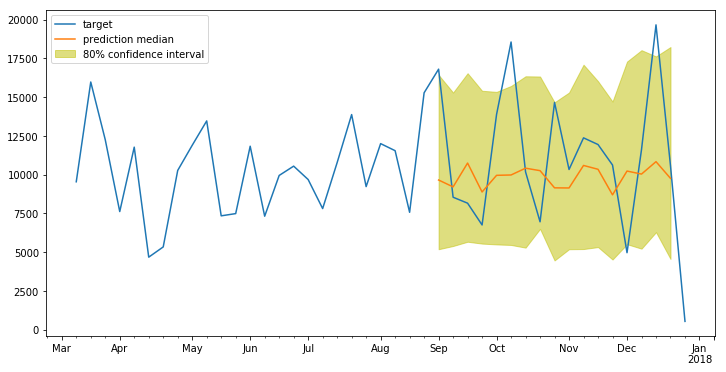

In [19]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

Now want to make predictions for all series

In [20]:
list_of_df = predictor.predict(pred_data)

In [21]:
list_of_df[2]

,0.1,0.5,0.9
2017-09-03,0.0,8.0,987.0
2017-09-10,0.0,21.0,822.0
2017-09-17,0.0,18.0,1069.0
2017-09-24,0.0,27.0,1049.0
2017-10-01,0.0,15.0,562.0
2017-10-08,0.0,33.0,579.0
2017-10-15,0.0,28.0,1248.0
2017-10-22,0.0,39.0,836.0
2017-10-29,0.0,0.0,541.0
2017-11-05,0.0,5.0,2117.0


Combine into single dataframe for storage and retrieval.  Add column to index which series the predictions refer to.

In [22]:
combined_preds = pd.DataFrame()

for n in range(len(list_of_df)):
    preds = list_of_df[n]
    preds["series_num"] = n
    combined_preds = combined_preds.append(preds)
    
combined_preds

,0.1,0.5,0.9,series_num
2017-09-03,0.0,4.0,3237.0,0
2017-09-10,0.0,0.0,1999.0,0
2017-09-17,0.0,1.0,2558.0,0
2017-09-24,0.0,0.0,2335.0,0
2017-10-01,0.0,0.0,1294.0,0
2017-10-08,0.0,0.0,1560.0,0
2017-10-15,0.0,0.0,1390.0,0
2017-10-22,0.0,0.0,1443.0,0
2017-10-29,0.0,0.0,610.0,0
2017-11-05,0.0,0.0,542.0,0


Store to S3

In [23]:
filepath = "{}/preds/combined_preds.csv".format(s3_data_path)

In [24]:
filepath

'sagemaker-w210-0223/Deeptest_1/data/preds/combined_preds.csv'

In [25]:
bytes_to_write = combined_preds.to_csv(None).encode()
fs = s3fs.S3FileSystem()

with fs.open(filepath, 'wb') as f:
    f.write(bytes_to_write)

Check we can read back

In [26]:
with fs.open(filepath, 'rb') as f:
    df2 = pd.read_csv(f, index_col = 0)

In [27]:
df2

,0.1,0.5,0.9,series_num
2017-09-03,0.0,4.0,3237.0,0
2017-09-10,0.0,0.0,1999.0,0
2017-09-17,0.0,1.0,2558.0,0
2017-09-24,0.0,0.0,2335.0,0
2017-10-01,0.0,0.0,1294.0,0
2017-10-08,0.0,0.0,1560.0,0
2017-10-15,0.0,0.0,1390.0,0
2017-10-22,0.0,0.0,1443.0,0
2017-10-29,0.0,0.0,610.0,0
2017-11-05,0.0,0.0,542.0,0


## Delete endpoint

Run this code to automatically delete the endpoint instance and stop getting billed for it...!

In [28]:
sagemaker_session.delete_endpoint(endpoint_name)

INFO:sagemaker:Deleting endpoint with name: DeepAR-M1-2018-04-08-18-45-45-002
